In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.colors import LogNorm # 导入对数颜色归一化
# 以下为机器学习相关库，本阶段未直接使用，但保留
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# 文件路径
file_path = 'dedx_sample_28_1000000.txt'

# 存储结果的列表
x_values_collected = []  # p/|z| values
y_values_collected = []  # truncated mean of dE/dx
mass_values_collected = []  # 质量值
momentum_values_collected = []  # 原始动量值
raw_dedx_values_collected = [] # 新增：存储每个粒子50个原始dE/dx值

particle_count = 0
start_time = time.time()

# 数据参数
NUM_DE_DX_VALUES = 50
TRUNCATE_COUNT = 30 # 初始截断值，这个值会在第三步被优化

print("Starting data processing with mass information...")

with open(file_path, 'r') as file:
    while True:
        header_line = file.readline()
        if not header_line:
            break

        try:
            header = header_line.strip().split(',')
            p = float(header[1])  # 动量
            mass = float(header[3])  # 质量（第四个数）
            z = 1 # 假设电荷为1，因为p/|z|中z为1
            x_val = p / abs(z) if z != 0 else 0

            # 读取50行dE/dx数据
            dedx_values_raw = [float(file.readline().strip()) for _ in range(NUM_DE_DX_VALUES)]
            dedx_array = np.array(dedx_values_raw)
            raw_dedx_values_collected.append(dedx_values_raw) # 新增：存储原始dE/dx值

            # 计算截断均值 (注意：此处仍使用初始TRUNCATE_COUNT，后续会优化)
            if TRUNCATE_COUNT > NUM_DE_DX_VALUES:
                truncated_mean = np.mean(dedx_array)
            else:
                dedx_smallest_values = np.partition(dedx_array, TRUNCATE_COUNT)[:TRUNCATE_COUNT]
                truncated_mean = np.mean(dedx_smallest_values)

            # 存储数据
            x_values_collected.append(x_val)
            y_values_collected.append(truncated_mean)
            mass_values_collected.append(mass)
            momentum_values_collected.append(p)

            particle_count += 1
            if particle_count % 100000 == 0:
                print(f"Processed {particle_count} particles... Time elapsed: {time.time() - start_time:.2f}s")

        except Exception as e:
            print(f"Error processing particle {particle_count}: {e}")
            # 如果读取出现问题，跳过该粒子并继续
            # 尝试跳过剩余的dE/dx行，以防止文件指针错位影响后续读取
            for _ in range(NUM_DE_DX_VALUES):
                file.readline()
            continue

# 转换为NumPy数组
x_values = np.array(x_values_collected)
y_values = np.array(y_values_collected)
mass_values = np.array(mass_values_collected)
momentum_values = np.array(momentum_values_collected)
raw_dedx_values = np.array(raw_dedx_values_collected) # 新增

print(f"Total particles processed: {particle_count}")
print(f"Unique masses found: {np.unique(mass_values)}")
print(f"Mass distribution: {[(mass, np.sum(mass_values == mass)) for mass in np.unique(mass_values)]}")

# >>> 关键修改：定义要分析的目标粒子质量，确保在任何引用它之前被定义 <<<
TARGET_MASS_FOR_RESOLUTION = 0.139 # GeV/c^2 (π介子) - 选择π介子作为分辨率分析的目标
print(f"\nTargeting resolution analysis for particles with mass: {TARGET_MASS_FOR_RESOLUTION} GeV/c^2 (e.g., Pions)")


Starting data processing with mass information...
Processed 100000 particles... Time elapsed: 10.96s
Processed 200000 particles... Time elapsed: 21.29s
Processed 300000 particles... Time elapsed: 31.41s
Processed 400000 particles... Time elapsed: 42.11s
Processed 500000 particles... Time elapsed: 53.39s
Processed 600000 particles... Time elapsed: 64.25s
Processed 700000 particles... Time elapsed: 77.80s
Processed 800000 particles... Time elapsed: 96.52s
Processed 900000 particles... Time elapsed: 108.86s
Processed 1000000 particles... Time elapsed: 175.30s
Total particles processed: 1000000
Unique masses found: [5.00e-04 1.39e-01 4.94e-01 9.37e-01]
Mass distribution: [(0.0005, 250794), (0.139, 249647), (0.494, 249664), (0.937, 249895)]

Targeting resolution analysis for particles with mass: 0.139 GeV/c^2 (e.g., Pions)


# 1.dE/dx分辨率基准分析
分辨率越小越好 - 0.1分辨率表示测量值平均波动10%，0.01就是只波动1%，精度提升10倍！


Calculating baseline resolution for mass 0.139 GeV/c^2...


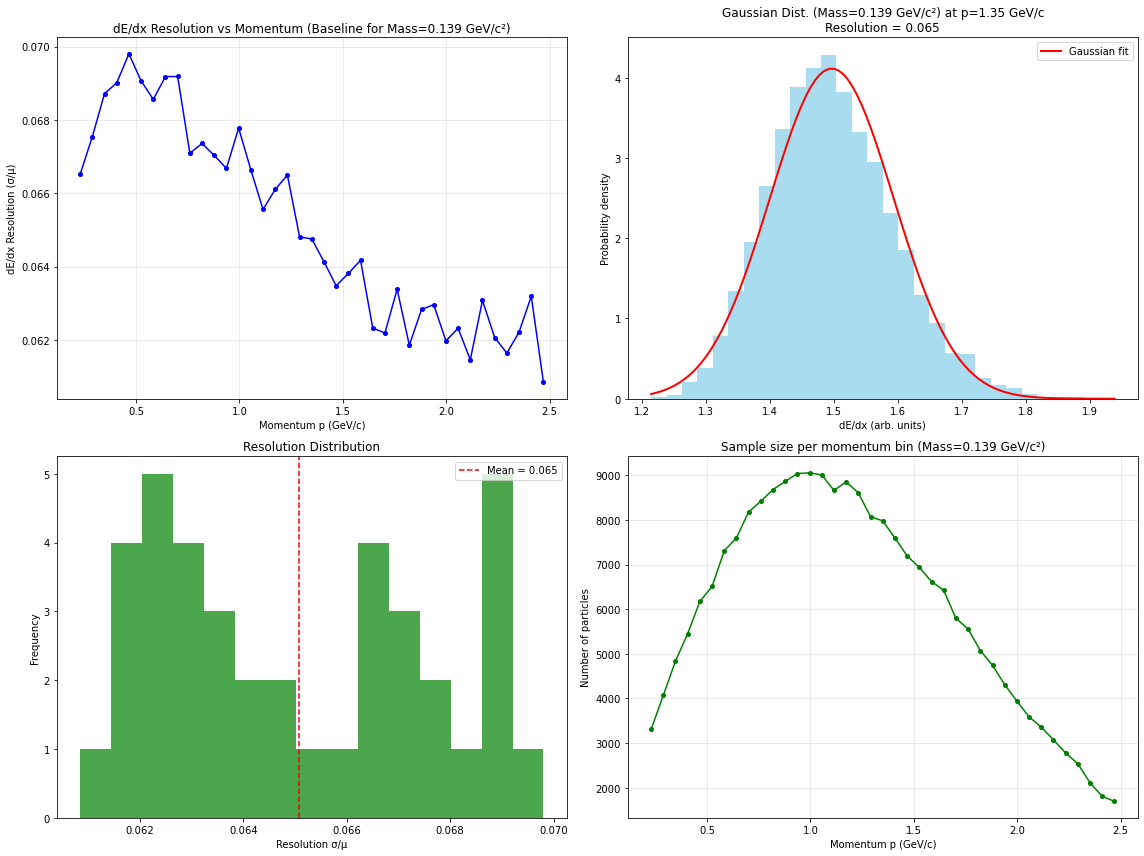

Average baseline resolution for mass 0.139 GeV/c^2: 0.0651
Resolution at p ~ 1.35 GeV/c for mass 0.139 GeV/c^2: 0.0648


In [4]:
def calculate_dedx_resolution(momentum_vals, dedx_vals, mass_vals, mass_to_filter, momentum_bins):
    """
    计算特定质量粒子在不同动量区间的dE/dx分辨率。
    新增 mass_vals 和 mass_to_filter 参数用于筛选粒子。
    """
    resolutions = []
    
    # 首先根据质量筛选数据
    mass_mask = (mass_vals == mass_to_filter)
    filtered_momentum_vals = momentum_vals[mass_mask]
    filtered_dedx_vals = dedx_vals[mass_mask]
    
    if len(filtered_momentum_vals) == 0:
        print(f"Warning: No particles found for mass {mass_to_filter} GeV/c^2 in the given data for resolution calculation.")
        return []

    for i in range(len(momentum_bins)-1):
        # 在已筛选的粒子中进行动量区间筛选
        mask = (filtered_momentum_vals >= momentum_bins[i]) & (filtered_momentum_vals < momentum_bins[i+1])
        
        if np.sum(mask) < 30:  # 确保有足够统计量
            continue
            
        dedx_slice = filtered_dedx_vals[mask]
        
        # 计算高斯分布参数
        mu = np.mean(dedx_slice)
        sigma = np.std(dedx_slice)
        resolution = sigma / mu if mu != 0 else 0
        
        resolutions.append({
            'momentum_center': (momentum_bins[i] + momentum_bins[i+1]) / 2,
            'momentum_range': (momentum_bins[i], momentum_bins[i+1]),
            'mean': mu,
            'sigma': sigma,
            'resolution': resolution,
            'n_points': np.sum(mask)
        })
    
    return resolutions

def plot_resolution_baseline(resolutions, all_momentum_values, all_dedx_values, all_mass_values, target_mass):
    """
    绘制分辨率基准。
    ax2现在仅对特定质量粒子的dE/dx分布进行高斯拟合。
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    momenta = [r['momentum_center'] for r in resolutions if r['resolution'] > 0]
    res_values = [r['resolution'] for r in resolutions if r['resolution'] > 0]
    
    # 分辨率 vs 动量 (针对特定质量粒子)
    ax1.plot(momenta, res_values, 'bo-', markersize=4)
    ax1.set_xlabel('Momentum p (GeV/c)')
    ax1.set_ylabel('dE/dx Resolution (σ/μ)')
    ax1.set_title(f'dE/dx Resolution vs Momentum (Baseline for Mass={target_mass} GeV/c²)')
    ax1.grid(True, alpha=0.3)
    
    # 选择中等动量区间展示高斯分布，优先选择 p=1.35 GeV/c 附近
    sample_res_found = False
    sample_resolution = None
    for res in resolutions:
        if res['momentum_center'] >= 1.3 and res['momentum_center'] < 1.4: # 聚焦1.35 GeV/c附近
            if res['n_points'] > 100: # 确保有足够点进行直方图绘制
                sample_resolution = res
                sample_res_found = True
                break
    
    if not sample_res_found and len(resolutions) > 0:
        # 如果1.3-1.4 GeV/c没有足够数据，退而求其次找一个中点
        mid_idx = len(resolutions) // 2
        sample_resolution = resolutions[mid_idx]
        print(f"Could not find sufficient data in 1.3-1.4 GeV/c range. Using sample at {sample_resolution['momentum_center']:.2f} GeV/c instead.")
    elif not sample_res_found and len(resolutions) == 0:
        ax2.text(0.5, 0.5, 'No resolution data available for plotting', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
        ax2.set_title('Gaussian Distribution (No data)')
        print("No resolution data available for baseline plotting.")
        # Make sure to handle the case where resolutions list is empty
        momenta = []
        res_values = []
        n_points = []

    if sample_resolution:
        # 获取该区间的数据，并再次通过质量进行筛选
        mask_for_hist = ((all_momentum_values >= sample_resolution['momentum_range'][0]) & 
                         (all_momentum_values < sample_resolution['momentum_range'][1]) &
                         (all_mass_values == target_mass)) # 关键：此处添加质量筛选
        sample_dedx = all_dedx_values[mask_for_hist]
        
        # 绘制直方图和高斯拟合
        if len(sample_dedx) > 30: # 确保有足够数据绘制直方图
            counts, bins, patches = ax2.hist(sample_dedx, bins=30, density=True, alpha=0.7, color='skyblue')
            
            # 高斯拟合曲线
            x_fit = np.linspace(sample_dedx.min(), sample_dedx.max(), 100)
            gaussian = (1/np.sqrt(2*np.pi*sample_resolution['sigma']**2)) * \
                       np.exp(-0.5*((x_fit - sample_resolution['mean'])/sample_resolution['sigma'])**2)
            ax2.plot(x_fit, gaussian, 'r-', linewidth=2, label='Gaussian fit')
            ax2.set_xlabel('dE/dx (arb. units)')
            ax2.set_ylabel('Probability density')
            ax2.set_title(f'Gaussian Dist. (Mass={target_mass} GeV/c²) at p={sample_resolution["momentum_center"]:.2f} GeV/c\n'
                          f'Resolution = {sample_resolution["resolution"]:.3f}')
            ax2.legend()
        else:
            ax2.text(0.5, 0.5, 'Not enough data for histogram in this bin', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
            ax2.set_title(f'Gaussian Distribution (Mass={target_mass} GeV/c²) at p={sample_resolution["momentum_center"]:.2f} GeV/c')
    
    # 分辨率分布直方图
    if len(res_values) > 0:
        ax3.hist(res_values, bins=15, alpha=0.7, color='green')
        ax3.set_xlabel('Resolution σ/μ')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Resolution Distribution')
        ax3.axvline(np.mean(res_values), color='red', linestyle='--', 
                    label=f'Mean = {np.mean(res_values):.3f}')
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, 'No resolution data available', horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)
        ax3.set_title('Resolution Distribution')
        
    # 统计量随动量的变化 (针对特定质量粒子)
    n_points = [r['n_points'] for r in resolutions]
    ax4.plot(momenta, n_points, 'go-', markersize=4)
    ax4.set_xlabel('Momentum p (GeV/c)')
    ax4.set_ylabel('Number of particles')
    ax4.set_title(f'Sample size per momentum bin (Mass={target_mass} GeV/c²)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('dedx_resolution_baseline_analysis_mass_filtered.png', dpi=300) # 保存为新的文件名
    plt.show()
    
    return resolutions

# 执行分辨率基准分析 (针对特定质量粒子)
narrow_momentum_bins = np.linspace(0.2, 2.5, 40)
print(f"\nCalculating baseline resolution for mass {TARGET_MASS_FOR_RESOLUTION} GeV/c^2...")
resolutions_mass_filtered = calculate_dedx_resolution(momentum_values, y_values, mass_values, TARGET_MASS_FOR_RESOLUTION, narrow_momentum_bins)

plot_resolution_baseline(resolutions_mass_filtered, momentum_values, y_values, mass_values, TARGET_MASS_FOR_RESOLUTION)

# 确保有有效的分辨率值用于计算平均
valid_resolutions_filtered = [r['resolution'] for r in resolutions_mass_filtered if r['resolution'] > 0]
if valid_resolutions_filtered:
    print(f"Average baseline resolution for mass {TARGET_MASS_FOR_RESOLUTION} GeV/c^2: {np.mean(valid_resolutions_filtered):.4f}")
    # 查找p=1.35 GeV/c附近的分辨率
    resolution_at_1_35 = [r['resolution'] for r in resolutions_mass_filtered if r['momentum_center'] >= 1.3 and r['momentum_center'] < 1.4]
    if resolution_at_1_35:
        print(f"Resolution at p ~ 1.35 GeV/c for mass {TARGET_MASS_FOR_RESOLUTION} GeV/c^2: {np.mean(resolution_at_1_35):.4f}")
    else:
        print(f"Could not find resolution data for p ~ 1.35 GeV/c for mass {TARGET_MASS_FOR_RESOLUTION} GeV/c^2.")
else:
    print(f"No valid baseline resolutions calculated for mass {TARGET_MASS_FOR_RESOLUTION} GeV/c^2.")



# 2.截断值优化
之前默认取50个读数中最小的30个，但这30是最佳选择吗？

通过调整对dE/dx值的截断（只考虑最小的一部分样本而非所有值）比例，找到最佳的截断百分比，从而改善能量损失的测量分辨率。

通过调整截断比例（从30%到100%，步长2%），观察不同比例下的分辨率变化


Starting truncation optimization for mass 0.139 GeV/c^2...
Testing truncation percentage: 30.0% for mass 0.139 GeV/c^2
Average resolution for 30.0%: 0.0660
Testing truncation percentage: 32.0% for mass 0.139 GeV/c^2
Average resolution for 32.0%: 0.0655
Testing truncation percentage: 34.0% for mass 0.139 GeV/c^2
Average resolution for 34.0%: 0.0652
Testing truncation percentage: 36.0% for mass 0.139 GeV/c^2
Average resolution for 36.0%: 0.0648
Testing truncation percentage: 38.0% for mass 0.139 GeV/c^2
Average resolution for 38.0%: 0.0646
Testing truncation percentage: 40.0% for mass 0.139 GeV/c^2
Average resolution for 40.0%: 0.0645
Testing truncation percentage: 42.0% for mass 0.139 GeV/c^2
Average resolution for 42.0%: 0.0644
Testing truncation percentage: 44.0% for mass 0.139 GeV/c^2
Average resolution for 44.0%: 0.0644
Testing truncation percentage: 46.0% for mass 0.139 GeV/c^2
Average resolution for 46.0%: 0.0644
Testing truncation percentage: 48.0% for mass 0.139 GeV/c^2
Average

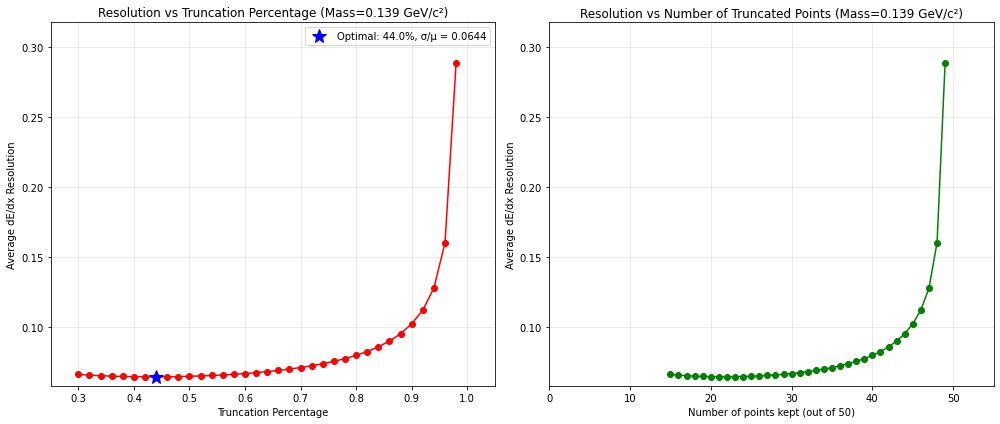


Optimal truncation percentage for mass 0.139 GeV/c^2: 44.0%
Optimal truncation count: 22
Best resolution achieved: 0.0644


In [10]:
def optimize_truncation_percentage(file_path, mass_to_optimize, truncation_percentages):
    """
    优化特定质量粒子的截断百分比以获得最佳分辨率。
    新增 mass_to_optimize 参数。
    """
    results = []
    
    for trunc_pct in truncation_percentages:
        print(f"Testing truncation percentage: {trunc_pct:.1%} for mass {mass_to_optimize} GeV/c^2")
        # 计算当前截断百分比对应的点数
        trunc_count = int(NUM_DE_DX_VALUES * trunc_pct)
        
        # 重新处理数据以获得不同截断值
        # 注意：此处读取所有粒子数据，但只计算当前截断百分比下的截断均值
        # 质量筛选将在 calculate_dedx_resolution 内部完成
        temp_momentum_all = []
        temp_dedx_all = []
        temp_mass_all = [] # 存储原始质量
        
        with open(file_path, 'r') as file:
            particle_count_sample = 0 # 使用不同的计数器以避免与全局particle_count混淆
            while True:
                header_line = file.readline()
                # 限制样本数加快计算，且避免文件读取错误
                if not header_line or particle_count_sample >= 500000: # 增加样本数到50万以获得更稳定的结果
                    break
                
                try:
                    header = header_line.strip().split(',')
                    p = float(header[1])
                    mass = float(header[3]) # 读取原始质量
                    
                    dedx_values_raw = [float(file.readline().strip()) for _ in range(NUM_DE_DX_VALUES)]
                    dedx_array = np.array(dedx_values_raw)
                    
                    # 使用当前截断百分比计算截断均值
                    if trunc_count >= NUM_DE_DX_VALUES: # 如果截断数大于等于总数，则取全部平均
                        truncated_mean = np.mean(dedx_array)
                    else:
                        dedx_smallest = np.partition(dedx_array, trunc_count)[:trunc_count]
                        truncated_mean = np.mean(dedx_smallest)
                    
                    temp_momentum_all.append(p)
                    temp_dedx_all.append(truncated_mean)
                    temp_mass_all.append(mass) # 存储原始质量
                    particle_count_sample += 1
                    
                except Exception as e:
                    # print(f"Error processing particle {particle_count_sample} during truncation optimization: {e}")
                    # 如果读取出现问题，跳过该粒子并继续
                    for _ in range(NUM_DE_DX_VALUES): # 尝试跳过剩余的dE/dx行
                        file.readline()
                    continue
        
        # 计算该截断值下特定质量粒子的分辨率
        # 动量区间选择相对稳定的范围，例如0.5-1.5 GeV/c
        momentum_bins = np.linspace(0.5, 1.5, 11) 
        temp_resolutions = calculate_dedx_resolution(np.array(temp_momentum_all), 
                                                   np.array(temp_dedx_all),
                                                   np.array(temp_mass_all), # 传入所有质量
                                                   mass_to_optimize, # 传入要优化的质量
                                                   momentum_bins)
        
        # 计算平均分辨率
        valid_resolutions = [r['resolution'] for r in temp_resolutions 
                           if r['resolution'] > 0 and r['resolution'] < 1] # 过滤掉异常值
        avg_resolution = np.mean(valid_resolutions) if valid_resolutions else float('inf')
        
        results.append({
            'truncation_percentage': trunc_pct,
            'truncation_count': trunc_count,
            'average_resolution': avg_resolution,
            'n_resolutions': len(valid_resolutions)
        })
        
        print(f"Average resolution for {trunc_pct:.1%}: {avg_resolution:.4f}")
    
    return results

def plot_truncation_optimization(truncation_results, target_mass):
    """
    绘制截断优化结果。
    图表标题更新以反映特定质量的优化。
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    percentages = [r['truncation_percentage'] for r in truncation_results if r['average_resolution'] != float('inf')]
    resolutions = [r['average_resolution'] for r in truncation_results if r['average_resolution'] != float('inf')]
    
    if not percentages:
        print("No valid truncation results to plot.")
        return

    # 分辨率 vs 截断百分比
    ax1.plot(percentages, resolutions, 'ro-', markersize=6)
    ax1.set_xlabel('Truncation Percentage')
    ax1.set_ylabel('Average dE/dx Resolution')
    ax1.set_title(f'Resolution vs Truncation Percentage (Mass={target_mass} GeV/c²)')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0.25, 1.05) # 稍微超出范围，确保100%可见
    ax1.set_ylim(min(resolutions)*0.9, max(resolutions)*1.1) # 动态调整Y轴

    # 找到最优点
    optimal_idx = np.argmin(resolutions)
    optimal_percentage = percentages[optimal_idx]
    optimal_resolution = resolutions[optimal_idx]
    
    ax1.plot(optimal_percentage, optimal_resolution, 'b*', markersize=15, 
             label=f'Optimal: {optimal_percentage:.1%}, σ/μ = {optimal_resolution:.4f}')
    ax1.legend()
    
    # 截断数量 vs 分辨率
    truncation_counts = [r['truncation_count'] for r in truncation_results if r['average_resolution'] != float('inf')]
    ax2.plot(truncation_counts, resolutions, 'go-', markersize=6)
    ax2.set_xlabel(f'Number of points kept (out of {NUM_DE_DX_VALUES})')
    ax2.set_ylabel('Average dE/dx Resolution')
    ax2.set_title(f'Resolution vs Number of Truncated Points (Mass={target_mass} GeV/c²)')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, NUM_DE_DX_VALUES + 5) # 稍微超出范围
    ax2.set_ylim(min(resolutions)*0.9, max(resolutions)*1.1)

    plt.tight_layout()
    plt.savefig('truncation_optimization_mass_filtered.png', dpi=300) # 保存为新的文件名
    plt.show()
    
    print(f"\nOptimal truncation percentage for mass {target_mass} GeV/c^2: {optimal_percentage:.1%}")
    print(f"Optimal truncation count: {truncation_results[optimal_idx]['truncation_count']}")
    print(f"Best resolution achieved: {optimal_resolution:.4f}")
    
    return optimal_percentage, optimal_resolution

# 执行截断优化
# 扩展范围到1.0 (100%)，步长可以适当细化
truncation_percentages = np.arange(0.3, 1.01, 0.02) # 从30%到100%，步长2%
print(f"\nStarting truncation optimization for mass {TARGET_MASS_FOR_RESOLUTION} GeV/c^2...")
truncation_results = optimize_truncation_percentage(file_path, TARGET_MASS_FOR_RESOLUTION, truncation_percentages)

optimal_trunc_pct, optimal_resolution = plot_truncation_optimization(truncation_results, TARGET_MASS_FOR_RESOLUTION)


# 3：速度变换验证
**目的：**
验证将动量转化为粒子的相对速度β后，dE/dx是否呈现出统一的关系（即“收敛”到单一的曲线），以验证Bethe-Bloch关系。

**原理：**

不同质量的粒子在相同动量下具有不同速度β。

通过计算β，将不同粒子的p-dE/dx关系变换到相同的速度标度，理论上应表现出一致性。

这验证了动量到速度的转换是否符合预期，以及不同质量粒子是否可以用统一的模型描述。

**实施：**

1.按粒子质量将数据分类，画出原始p与dE/dx关系（不同颜色表示不同质量）。

2.计算β（p/√(p² + m²)），重新绘制β与dE/dx关系。

3.观察变换后，各质量样本是否“会聚”到一条单一关系线。

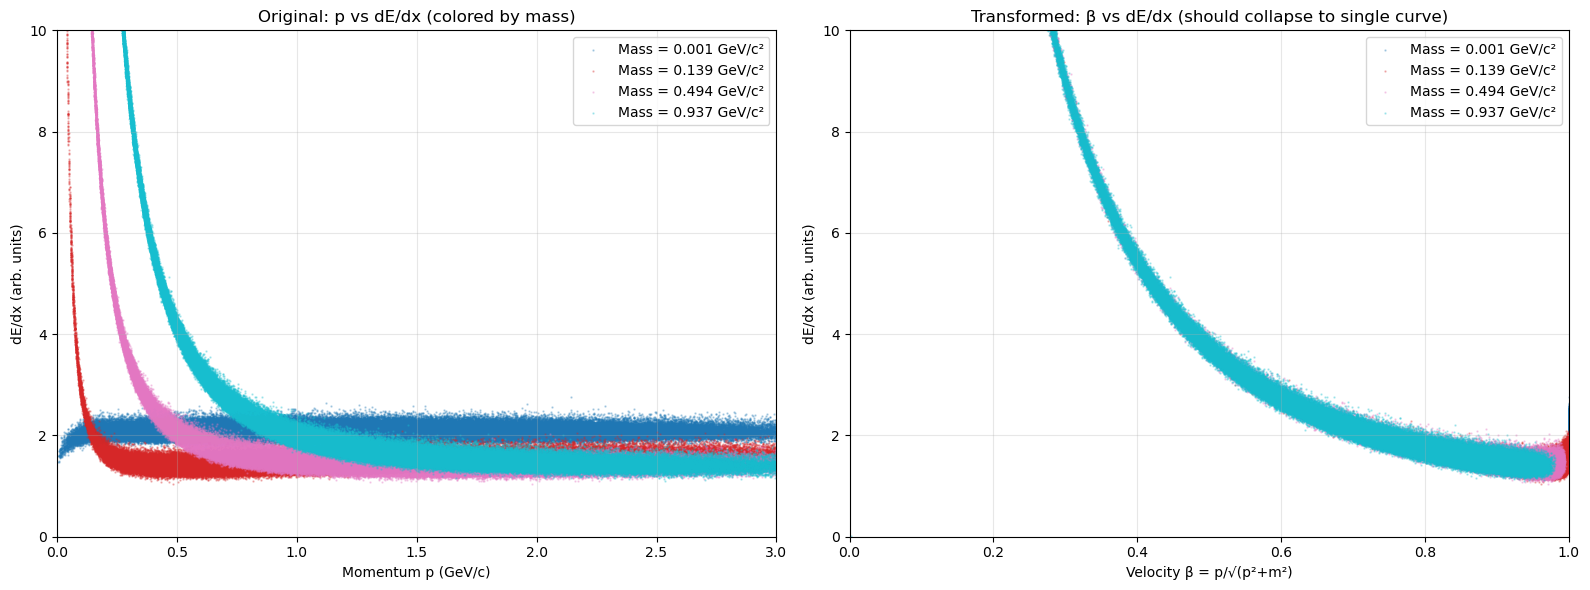


=== Velocity Transform Verification ===
Mass 0.001 GeV/c²: 250794 particles, β range: 0.979 - 1.000
Mass 0.139 GeV/c²: 249647 particles, β range: 0.009 - 1.000
Mass 0.494 GeV/c²: 249664 particles, β range: 0.005 - 0.996
Mass 0.937 GeV/c²: 249895 particles, β range: 0.002 - 0.980


In [4]:
def velocity_transform_analysis(momentum_vals, dedx_vals, mass_vals):
    """速度变换分析，验证Bethe-Bloch关系"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 获取不同的质量值
    unique_masses = np.unique(mass_vals)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_masses)))
    
    # 原始 p vs dE/dx（按质量分类）
    for i, mass in enumerate(unique_masses):
        mask = mass_vals == mass
        if np.sum(mask) > 100:  # 只显示有足够统计量的质量
            ax1.scatter(momentum_vals[mask], dedx_vals[mask], 
                       s=0.5, alpha=0.3, color=colors[i], 
                       label=f'Mass = {mass:.3f} GeV/c²')
    
    ax1.set_xlabel('Momentum p (GeV/c)')
    ax1.set_ylabel('dE/dx (arb. units)')
    ax1.set_title('Original: p vs dE/dx (colored by mass)')
    ax1.legend()
    ax1.set_xlim(0, 3)
    ax1.set_ylim(0, 10)
    ax1.grid(True, alpha=0.3)
    
    # 转换后的 β vs dE/dx
    for i, mass in enumerate(unique_masses):
        mask = mass_vals == mass
        if np.sum(mask) > 100:
            # 计算速度 β = p/√(p²+m²)
            p_subset = momentum_vals[mask]
            beta = p_subset / np.sqrt(p_subset**2 + mass**2)
            
            ax2.scatter(beta, dedx_vals[mask], s=0.5, alpha=0.3, 
                       color=colors[i], label=f'Mass = {mass:.3f} GeV/c²')
    
    ax2.set_xlabel('Velocity β = p/√(p²+m²)')
    ax2.set_ylabel('dE/dx (arb. units)')
    ax2.set_title('Transformed: β vs dE/dx (should collapse to single curve)')
    ax2.legend()
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('velocity_transform_verification.png', dpi=300)
    plt.show()
    
    # 计算变换效果的定量评估
    print("\n=== Velocity Transform Verification ===")
    for mass in unique_masses:
        mask = mass_vals == mass
        if np.sum(mask) > 100:
            p_subset = momentum_vals[mask]
            beta = p_subset / np.sqrt(p_subset**2 + mass**2)
            print(f"Mass {mass:.3f} GeV/c²: {np.sum(mask)} particles, β range: {beta.min():.3f} - {beta.max():.3f}")

# 执行速度变换验证
velocity_transform_analysis(momentum_values, y_values, mass_values)


# 4.基于MLP回归器预测 <dE/dx> (基于速度)
1.绘制 MLP 预测的曲线。专门针对一种粒子的数据进行训练

定量评估：计算模型在测试集上的均方误差（MSE）或平均绝对误差（MAE），以衡量预测曲线与实际数据点的拟合程度。

2.MLP分类器：训练一个MLP分类器来区分重叠动量区域的粒子，并将其性能（通过ROC曲线）与基于截断均值的方法进行比较。

In [ ]:
## MLP 回归器 - 替代 Bethe-Bloch 参数化 (优化版)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import itertools

# --- 1. 数据加载与处理 ---
# 假设您已经加载了 momentum_values, mass_values, y_values (截断均值)
# 您的数据加载和预处理代码应在此处

# 仅使用π介子数据进行训练
TARGET_MASS_FOR_TRAINING = 0.139
pion_mask = (mass_values == TARGET_MASS_FOR_TRAINING)
pion_momentum = momentum_values[pion_mask]
pion_dedx_truncated = y_values[pion_mask]

# --- 2. 特征工程：计算速度 beta ---
velocity_values = pion_momentum / np.sqrt(pion_momentum**2 + TARGET_MASS_FOR_TRAINING**2)
velocity_values = np.clip(velocity_values, 1e-6, 1.0 - 1e-6)

# 对 dE/dx 标签进行对数变换，以处理其偏斜分布
# 添加一个小的常数以避免log(0)
epsilon = 1e-6
y_reg_full_log = np.log(pion_dedx_truncated + epsilon).reshape(-1, 1)

X_reg_full = velocity_values.reshape(-1, 1)

# --- 3. 数据标准化与划分 ---
scaler_X_reg = StandardScaler()
scaler_y_reg_log = StandardScaler()
X_reg_scaled = scaler_X_reg.fit_transform(X_reg_full)
y_reg_scaled_log = scaler_y_reg_log.fit_transform(y_reg_full_log)

X_reg_train, X_reg_test, y_reg_train_log, y_reg_test_log = train_test_split(
    X_reg_scaled, y_reg_scaled_log, test_size=0.2, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
X_reg_train_tensor = torch.tensor(X_reg_train, dtype=torch.float32).to(device)
y_reg_train_tensor_log = torch.tensor(y_reg_train_log, dtype=torch.float32).to(device)

train_dataset_reg = TensorDataset(X_reg_train_tensor, y_reg_train_tensor_log)

# --- 4. 定义 MLP 模型 (改进版，带 Dropout) ---
class BetaMLPRegressorOptimized(nn.Module):
    def __init__(self, hidden_size, dropout_rate=0.2):
        super(BetaMLPRegressorOptimized, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, 1)
        )
    
    def forward(self, x):
        return self.net(x)

# --- 5. 超参数网格搜索 ---
param_grid = {
    'hidden_size': [64, 128],
    'lr': [0.001, 0.0001],
    'weight_decay': [0, 1e-4]
}

best_rmse = float('inf')
best_params = {}
results = []

for hidden_size, lr, weight_decay in itertools.product(
    param_grid['hidden_size'], param_grid['lr'], param_grid['weight_decay']):

    print(f"\nTraining with params: hidden_size={hidden_size}, lr={lr}, weight_decay={weight_decay}")

    # 模型、损失函数、优化器
    beta_model = BetaMLPRegressorOptimized(hidden_size).to(device)
    criterion_reg = nn.MSELoss()
    optimizer_reg = optim.Adam(beta_model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # DataLoader
    train_loader_reg = DataLoader(train_dataset_reg, batch_size=256, shuffle=True)

    # 训练循环
    num_epochs = 50  # 减少 epoch 数量以加速网格搜索
    for epoch in range(num_epochs):
        beta_model.train()
        for inputs, labels in train_loader_reg:
            optimizer_reg.zero_grad()
            outputs = beta_model(inputs)
            loss = criterion_reg(outputs, labels)
            loss.backward()
            optimizer_reg.step()
    
    # 评估模型性能
    beta_model.eval()
    with torch.no_grad():
        X_reg_test_tensor = torch.tensor(X_reg_test, dtype=torch.float32).to(device)
        test_preds_scaled_log = beta_model(X_reg_test_tensor).cpu().numpy()
        
        # 将预测值反变换回原始空间
        test_preds_original_log = scaler_y_reg_log.inverse_transform(test_preds_scaled_log)
        test_preds_original = np.exp(test_preds_original_log) - epsilon

        # 原始的真实值
        y_reg_test_original_log = scaler_y_reg_log.inverse_transform(y_reg_test_log)
        y_reg_test_original = np.exp(y_reg_test_original_log) - epsilon

        # 计算在原始空间中的 RMSE
        rmse = np.sqrt(mean_squared_error(y_reg_test_original, test_preds_original))
        results.append({
            'params': (hidden_size, lr, weight_decay),
            'rmse': rmse
        })
        print(f"-> Test RMSE on original data: {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'hidden_size': hidden_size, 'lr': lr, 'weight_decay': weight_decay}
        torch.save(beta_model.state_dict(), 'best_beta_regressor_model.pth')
        print("   Found new best model, saving...")

print("\n--- Hyperparameter Search Finished ---")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best parameters: {best_params}")

# --- 6. 使用最优模型进行可视化 ---
print("\nLoading and visualizing the best model...")
best_model = BetaMLPRegressorOptimized(best_params['hidden_size']).to(device)
best_model.load_state_dict(torch.load('best_beta_regressor_model.pth'))

test_beta_smooth = np.linspace(0.01, 1, 500).reshape(-1, 1)
test_beta_scaled = scaler_X_reg.transform(test_beta_smooth)
test_beta_tensor = torch.tensor(test_beta_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    best_model.eval()
    pred_y_scaled_log = best_model(test_beta_tensor).cpu().numpy()
    pred_y_original_log = scaler_y_reg_log.inverse_transform(pred_y_scaled_log)
    pred_y_original = np.exp(pred_y_original_log) - epsilon

plt.figure(figsize=(10, 8))
plt.scatter(velocity_values, pion_dedx_truncated, s=1, alpha=0.1, label='Pion Data Points')
plt.plot(test_beta_smooth, pred_y_original, color='red', lw=3, label='MLP Predicted Curve (Optimized)')
plt.xlabel(r"Velocity $\beta = p/\sqrt{p^2+m^2}$")
plt.ylabel(r"$\langle\mathrm{dE}/\mathrm{dx}\rangle$ (arb. units)")
plt.title(r"Optimized MLP Regressor: Predicted $\langle\mathrm{dE}/\mathrm{dx}\rangle$ vs Velocity")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 10)
plt.tight_layout()
plt.savefig('beta_mlp_regressor_optimized_prediction.png', dpi=300)
plt.show()



# 以上都不做修改

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix
import scipy.stats as stats # 用于计算偏度、峰度

# --- 1. 数据加载与处理 ---
file_path = 'dedx_sample_28_1000000.txt'

dedx_inputs_collected = [] # 存储50个原始dE/dx值
truncated_means_collected_for_comp = [] # 存储截断均值用于ROC比较
mass_values_collected = []
momentum_values_collected = []

NUM_DE_DX_VALUES = 50
TRUNCATE_COUNT_OPTIMAL = 22 # 使用第三步优化的截断值

particle_count = 0
start_time = time.time()
print("\nStarting data processing for MLP classifier (with enhanced features)...")

with open(file_path, 'r') as file:
    while True:
        header_line = file.readline()
        if not header_line:
            break

        try:
            header = header_line.strip().split(',')
            p = float(header[1])
            mass = float(header[3])
            
            dedx_values_raw = [float(file.readline().strip()) for _ in range(NUM_DE_DX_VALUES)]
            dedx_array = np.array(dedx_values_raw)
            
            # 使用最优截断值计算截断均值 (用于ROC比较的基准)
            if TRUNCATE_COUNT_OPTIMAL > NUM_DE_DX_VALUES:
                truncated_mean_comp = np.mean(dedx_array)
            else:
                dedx_smallest_values = np.partition(dedx_array, TRUNCATE_COUNT_OPTIMAL)[:TRUNCATE_COUNT_OPTIMAL]
                truncated_mean_comp = np.mean(dedx_smallest_values)

            # 按升序排列原始 dedx 值作为基础特征
            sorted_dedx_array = np.sort(dedx_array)
            
            # --- 新增：计算额外的统计特征 ---
            mean_dedx = np.mean(dedx_array) # 原始均值
            std_dedx = np.std(dedx_array) # 标准差
            median_dedx = np.median(dedx_array) # 中位数
            # 偏度 (Skewness) 和 峰度 (Kurtosis) 衡量分布形状
            skew_dedx = stats.skew(dedx_array)
            kurt_dedx = stats.kurtosis(dedx_array)
            
            # 将所有特征合并
            combined_features = np.concatenate((sorted_dedx_array, 
                                                 [mean_dedx, std_dedx, median_dedx, 
                                                  skew_dedx, kurt_dedx]))
            
            dedx_inputs_collected.append(combined_features)
            
            truncated_means_collected_for_comp.append(truncated_mean_comp)
            mass_values_collected.append(mass)
            momentum_values_collected.append(p)

            particle_count += 1
            if particle_count % 100000 == 0:
                print(f"Processed {particle_count} particles... Time elapsed: {time.time() - start_time:.2f}s")
        
        except Exception as e:
            # print(f"Error processing particle {particle_count}: {e}") # 打印错误可以帮助调试
            for _ in range(NUM_DE_DX_VALUES): # 尝试跳过剩余的dE/dx行
                file.readline()
            continue

print(f"Total particles processed: {particle_count}")

X_data_full = np.array(dedx_inputs_collected)
y_truncated_mean_full = np.array(truncated_means_collected_for_comp) # 仅用于比较
mass_data_full = np.array(mass_values_collected)
momentum_data_full = np.array(momentum_values_collected)

# --- 2. 筛选用于分类的样本 ---
TARGET_MASS_1 = 0.139 # π介子
TARGET_MASS_2 = 0.937 # 质子

MOMENTUM_OVERLAP_MIN = 1.0
MOMENTUM_OVERLAP_MAX = 2.0

mask_pions_all = (mass_data_full == TARGET_MASS_1) & \
                 (momentum_data_full >= MOMENTUM_OVERLAP_MIN) & \
                 (momentum_data_full < MOMENTUM_OVERLAP_MAX)
mask_protons_all = (mass_data_full == TARGET_MASS_2) & \
                   (momentum_data_full >= MOMENTUM_OVERLAP_MIN) & \
                   (momentum_data_full < MOMENTUM_OVERLAP_MAX)

# 从原始全量数据中筛选出用于分类的X, p, dedx_mean
X_pions = X_data_full[mask_pions_all]
X_protons = X_data_full[mask_protons_all]
p_pions = momentum_data_full[mask_pions_all]
p_protons = momentum_data_full[mask_protons_all]
dedx_pions = y_truncated_mean_full[mask_pions_all]
dedx_protons = y_truncated_mean_full[mask_protons_all]


print(f"\nNumber of pions in momentum range {MOMENTUM_OVERLAP_MIN}-{MOMENTUM_OVERLAP_MAX} GeV/c: {len(X_pions)}")
print(f"Number of protons in momentum range {MOMENTUM_OVERLAP_MIN}-{MOMENTUM_OVERLAP_MAX} GeV/c: {len(X_protons)}")

# 为分类器准备标签
X_classifier = np.vstack((X_pions, X_protons))
y_classifier = np.hstack((np.zeros(len(X_pions)), np.ones(len(X_protons)))) # 0 for pion, 1 for proton

# 将原始动量和dE/dx与分类器输入同步
p_classifier = np.hstack((p_pions, p_protons))
dedx_classifier = np.hstack((dedx_pions, dedx_protons))

# --- 3. 标准化和划分数据集 (新增验证集) ---
scaler_classifier = StandardScaler()
X_classifier_scaled = scaler_classifier.fit_transform(X_classifier)

# 第一次划分：训练+验证集 和 测试集
# 注意：现在我们也要将p_classifier和dedx_classifier一起划分
X_train_val, X_test, y_train_val, y_test, \
p_train_val, p_test, dedx_train_val, dedx_test = train_test_split(
    X_classifier_scaled, y_classifier, p_classifier, dedx_classifier,
    test_size=0.2, random_state=42, stratify=y_classifier) # 20%测试集

# 第二次划分：训练集 和 验证集
X_train, X_val, y_train, y_val, \
p_train, p_val, dedx_train, dedx_val = train_test_split(
    X_train_val, y_train_val, p_train_val, dedx_train_val,
    test_size=0.25, random_state=42, stratify=y_train_val) # 训练集占总体的 0.8 * 0.75 = 60%, 验证集占 0.8 * 0.25 = 20%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device for classifier: {device}")

# 转换为Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device).reshape(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device) # 测试集也转换为tensor，方便评估

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False) # 验证集不需要shuffle

# --- 4. 定义和训练 MLP 分类器 (改进版) ---
input_size = X_classifier_scaled.shape[1] # 动态获取输入特征的数量 (50 + 5 = 55)
hidden_size_classifier = 256 # 增加隐藏层大小

class MLPClassifierOptimized(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLPClassifierOptimized, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(), # 尝试LeakyReLU
            nn.Dropout(0.4), # 调整Dropout率
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_size // 2, hidden_size // 4), # 增加一层
            nn.BatchNorm1d(hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_size // 4, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

model_classifier = MLPClassifierOptimized(input_size, hidden_size_classifier).to(device)

criterion_classifier = nn.BCELoss() # 二元交叉熵损失
optimizer_classifier = optim.Adam(model_classifier.parameters(), lr=0.001, weight_decay=1e-5)

# --- 学习率调度器 ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_classifier, 'min', patience=5, factor=0.5, verbose=True)

# --- 早停机制 ---
patience = 15 # 容忍多少个epoch验证损失没有改善
min_delta = 1e-4 # 最小改进量
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

num_epochs = 200 # 增加最大epoch数，由早停控制实际训练长度
print("\nStarting MLP classifier training (optimized)...")

for epoch in range(num_epochs):
    model_classifier.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer_classifier.zero_grad()
        outputs = model_classifier(inputs)
        loss = criterion_classifier(outputs, labels)
        loss.backward()
        optimizer_classifier.step()
        running_loss += loss.item()
    
    # --- 验证阶段 ---
    model_classifier.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model_classifier(inputs)
            loss = criterion_classifier(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # 学习率调度
    scheduler.step(avg_val_loss)

    # 早停检查
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model_classifier.state_dict(), 'best_mlp_classifier_optimized.pth') # 保存最佳模型
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}!")
            early_stop = True
            break

    if early_stop:
        break

print("MLP classifier training finished.")
# 加载最佳模型权重
model_classifier.load_state_dict(torch.load('best_mlp_classifier_optimized.pth'))


# ======================== 第七步：比较ROC曲线 (无需修改，因为它使用现有的数据和测试集) ========================
from sklearn.metrics import roc_curve, auc

# --- 1. MLP 分类器预测 ---
model_classifier.eval()
with torch.no_grad():
    y_scores_mlp = model_classifier(X_test_tensor).cpu().numpy().flatten()
    
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_scores_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# --- 2. 截断均值法预测 ---
# y_truncated_mean_comp 和 y_true_comp 是全量数据，需要筛选出测试集对应的部分
# 这里我们使用在动量重叠区域筛选出的原始截断均值数据
# X_classifier_scaled, y_classifier 是用于 MLP 的数据
# y_truncated_pions_comp, y_truncated_protons_comp 是截断均值法的数据

# 使用原始的 y_truncated_mean_full 和 mass_data_full 来筛选出用于ROC比较的数据
# 确保这里的数据与分类器所用的动量范围一致
mask_pions_roc_comp = (mass_data_full == TARGET_MASS_1) & \
                      (momentum_data_full >= MOMENTUM_OVERLAP_MIN) & \
                      (momentum_data_full < MOMENTUM_OVERLAP_MAX)
mask_protons_roc_comp = (mass_data_full == TARGET_MASS_2) & \
                        (momentum_data_full >= MOMENTUM_OVERLAP_MIN) & \
                        (momentum_data_full < MOMENTUM_OVERLAP_MAX)

y_scores_truncated = np.hstack((y_truncated_mean_full[mask_pions_roc_comp], y_truncated_mean_full[mask_protons_roc_comp]))
y_true_truncated = np.hstack((np.zeros(np.sum(mask_pions_roc_comp)), np.ones(np.sum(mask_protons_roc_comp))))

fpr_truncated, tpr_truncated, _ = roc_curve(y_true_truncated, y_scores_truncated)
roc_auc_truncated = auc(fpr_truncated, tpr_truncated)


# --- 3. 绘图比较 ---
plt.figure(figsize=(10, 8))
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, 
         label=f'MLP Classifier (AUC = {roc_auc_mlp:.4f})')
plt.plot(fpr_truncated, tpr_truncated, color='blue', lw=2, linestyle='--',
         label=f'Truncated Mean (AUC = {roc_auc_truncated:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Proton identified as Pion)')
plt.ylabel('True Positive Rate (Proton identified as Proton)')
plt.title(f'ROC Curve Comparison (Pion vs Proton) in p={MOMENTUM_OVERLAP_MIN}-{MOMENTUM_OVERLAP_MAX} GeV/c')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('mlp_classifier_roc_comparison_optimized.png', dpi=300) # 保存为新的文件名
plt.show()

print("\n--- ROC Curve Comparison Results (Optimized MLP) ---")
print(f"MLP Classifier AUC: {roc_auc_mlp:.4f}")
print(f"Truncated Mean AUC: {roc_auc_truncated:.4f}")



In [ ]:

# ======================== 新增部分：可视化dE/dx vs p分类结果 (已修改) ========================
print("\n--- Visualizing MLP Classifier Performance on dE/dx vs Momentum ---")

# 从MLP分类器的分数中获取二值预测
# 阈值通常取0.5，Sigmoid输出 > 0.5 认为是正类 (质子)
prediction_threshold = 0.5 
y_pred_mlp_binary = (y_scores_mlp >= prediction_threshold).astype(int)

# 准备绘图数据
# p_test 和 dedx_test 是在数据划分时与X_test一起保留下来的原始动量和dE/dx数据
p_plot = p_test
dedx_plot = dedx_test
y_true_plot = y_test
y_pred_plot = y_pred_mlp_binary

# 根据真实标签和预测标签进行分类
# True Positive (TP): 真实质子, 预测质子
mask_tp = (y_true_plot == 1) & (y_pred_plot == 1)
# True Negative (TN): 真实π介子, 预测π介子
mask_tn = (y_true_plot == 0) & (y_pred_plot == 0)
# False Positive (FP): 真实π介子, 预测质子 (误报)
mask_fp = (y_true_plot == 0) & (y_pred_plot == 1)
# False Negative (FN): 真实质子, 预测π介子 (漏报)
mask_fn = (y_true_plot == 1) & (y_pred_plot == 0)

plt.figure(figsize=(12, 9))

# 绘制 TP (质子, 正确识别)
plt.scatter(p_plot[mask_tp], dedx_plot[mask_tp], 
            s=5, alpha=0.3, color='red', marker='s', label=f'Proton (TP, Correctly Identified) N={np.sum(mask_tp)}')
# 绘制 TN (π介子, 正确识别)
plt.scatter(p_plot[mask_tn], dedx_plot[mask_tn], 
            s=5, alpha=0.3, color='blue', marker='o', label=f'Pion (TN, Correctly Identified) N={np.sum(mask_tn)}')
# 绘制 FP (π介子, 错误识别为质子)
plt.scatter(p_plot[mask_fp], dedx_plot[mask_fp], 
            s=20, alpha=0.8, color='orange', marker='x', label=f'Pion (FP, Misidentified as Proton) N={np.sum(mask_fp)}') # 醒目的橙色叉
# 绘制 FN (质子, 错误识别为π介子)
plt.scatter(p_plot[mask_fn], dedx_plot[mask_fn], 
            s=20, alpha=0.8, color='purple', marker='^', label=f'Proton (FN, Misidentified as Pion) N={np.sum(mask_fn)}') # 醒目的紫色倒三角

plt.xlabel(r'$p$ (GeV/c)', fontsize=12)
plt.ylabel('TPC dE/dx signal (arb. unit)', fontsize=12)
plt.title(f'MLP Classifier Performance: dE/dx vs. Momentum (p={MOMENTUM_OVERLAP_MIN}-{MOMENTUM_OVERLAP_MAX} GeV/c)', fontsize=14)
# 调整图例字体大小 (假设默认字体大小是10或12，这里设置为30或36以实现三倍效果)
# plt.rcParams['font.size'] 是获取当前默认字体大小的方法
legend_font_size = plt.rcParams.get('font.size', 10) * 2
plt.legend(loc='upper left', markerscale=2, scatterpoints=1, fontsize=legend_font_size)
plt.grid(True, linestyle='--', alpha=0.6)

# 设置轴范围，聚焦在重叠区域
plt.xlim(MOMENTUM_OVERLAP_MIN, MOMENTUM_OVERLAP_MAX)
# !!! 教授建议修改：将y轴范围从0-10修改为0-3 !!!
plt.ylim(0, 3) # dE/dx的常用范围

plt.tight_layout()
plt.savefig('mlp_classifier_performance_scatter_zoomed.png', dpi=300) # 保存为新的文件名
plt.show()

print(f"Plot saved to mlp_classifier_performance_scatter_zoomed.png")

print(f"TP: {np.sum(mask_tp)}, TN: {np.sum(mask_tn)}, FP: {np.sum(mask_fp)}, FN: {np.sum(mask_fn)}")

In [ ]:


# ======================== 新增部分：真阳性率和真阴性率随动量变化的曲线 (根据教授建议) ========================
print("\n--- Plotting True Positive Rate and True Negative Rate vs Momentum ---")

# 定义更小的动量区间
# 教授提到在1到1.5可能分离很好，1.5到2可能完全重叠
# 我们可以在1.0到2.0的范围内创建更细的动量bin
momentum_bins_for_rates = np.linspace(MOMENTUM_OVERLAP_MIN, MOMENTUM_OVERLAP_MAX, 11) # 例如分成10个区间

momentum_centers = []
true_positive_rates = [] # TPR = TP / (TP + FN)
true_negative_rates = [] # TNR = TN / (TN + FP)
false_positive_rates = [] # FPR = FP / (FP + TN)
false_negative_rates = [] # FNR = FN / (FN + TP)
n_points_per_bin = []

# 对测试集数据进行循环，根据动量区间计算指标
for i in range(len(momentum_bins_for_rates) - 1):
    p_min = momentum_bins_for_rates[i]
    p_max = momentum_bins_for_rates[i+1]
    
    # 筛选当前动量区间内的测试集数据
    bin_mask = (p_test >= p_min) & (p_test < p_max)
    
    current_y_true = y_test[bin_mask]
    current_y_pred = y_pred_mlp_binary[bin_mask]
    
    if len(current_y_true) < 50: # 确保有足够的统计量，例如至少50个点
        # print(f"Skipping bin {p_min:.2f}-{p_max:.2f} due to insufficient data ({len(current_y_true)} points).")
        continue

    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(current_y_true, current_y_pred, labels=[0, 1]).ravel()
    
    # 避免除以零
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    momentum_centers.append((p_min + p_max) / 2)
    true_positive_rates.append(tpr)
    true_negative_rates.append(tnr)
    false_positive_rates.append(fpr)
    false_negative_rates.append(fnr)
    n_points_per_bin.append(len(current_y_true))
    
    print(f"Bin {p_min:.2f}-{p_max:.2f} GeV/c: TPR={tpr:.4f}, TNR={tnr:.4f}, FPR={fpr:.4f}, FNR={fnr:.4f}, N={len(current_y_true)}")

if not momentum_centers:
    print("No sufficient data in any momentum bin to plot performance vs momentum.")
else:
    plt.figure(figsize=(12, 7))
    plt.plot(momentum_centers, true_positive_rates, 'o-', color='red', label='True Positive Rate (Proton)')
    plt.plot(momentum_centers, true_negative_rates, 'o-', color='blue', label='True Negative Rate (Pion)')
    plt.plot(momentum_centers, false_positive_rates, 'x--', color='orange', label='False Positive Rate (Pion misid as Proton)')
    plt.plot(momentum_centers, false_negative_rates, '^--', color='purple', label='False Negative Rate (Proton misid as Pion)')
    
    plt.xlabel('Momentum p (GeV/c)', fontsize=12)
    plt.ylabel('Rate', fontsize=12)
    plt.title(f'MLP Classifier Performance vs. Momentum (p={MOMENTUM_OVERLAP_MIN}-{MOMENTUM_OVERLAP_MAX} GeV/c)', fontsize=14)
    plt.legend(loc='lower left', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(0, 1.05) # Rates are between 0 and 1
    plt.xlim(MOMENTUM_OVERLAP_MIN, MOMENTUM_OVERLAP_MAX)
    
    plt.tight_layout()
    plt.savefig('mlp_classifier_performance_vs_momentum.png', dpi=300)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(momentum_centers, n_points_per_bin, 'g-')
    plt.xlabel('Momentum p (GeV/c)', fontsize=12)
    plt.ylabel('Number of Test Particles', fontsize=12)
    plt.title('Number of Particles per Momentum Bin (Test Set)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(MOMENTUM_OVERLAP_MIN, MOMENTUM_OVERLAP_MAX)
    plt.tight_layout()
    plt.savefig('mlp_classifier_particles_per_bin.png', dpi=300)
    plt.show()
